# Business Understanding

## Business context

Cancellations cause significant revenue losses for the hotel business every year. Rooms that could have been occupied by other visitors are left empty due to high cancellation rates. These losses have a direct effect on profitability and pose logistical problems for staffing, guest expectations, and booking management. Peak seasons, when demand is high and cancellations lower potential earnings, make the problem even more urgent.

## Business objectives

The objective of this project is to use historical booking data to predict whether a booking will be cancelled or not. This will allow the hotel to take preventive measures to reduce the number of cancellations and increase revenue. The model will use some information about the booking, such as the number of days the booking was made in advance, the type of the customer, the number of special requests, among others, to make the predictions.

## Criteria of Success

In this project, it is important for the model to correctly identify as many potential cancellations as possible to help the hotel reduce losses. Missing a cancellation (false negative) means the hotel could end up with empty rooms, losing revenue.

To evaluate the model’s success, we will use these metrics:

- Precision: Measures how many of the bookings predicted as cancellations were actually canceled.
- Recall: Measures how many actual cancellations the model was able to catch, helping minimize missed cancellations.
- F1 Score: Balances precision and recall, giving a single score for overall model reliability.

We aim for a model with high recall and a good F1 score, which would mean it is catching most cancellations while remaining reliable. This will allow the hotel to take proactive actions to manage room availability and reduce revenue losses.

## Business questions

What are the strongest predictors of booking cancellations?
- Identifying the factors most closely associated with cancellations will help the hotel refine its policies, booking requirements, and customer engagement strategies.

How effective is the model in predicting cancellations for targeted operational adjustments?
- An effective model will empower hotel management to adjust inventory planning, overbooking policies, and pricing strategies based on cancellation likelihood.

What actions can be taken to reduce the probability of cancellation?
- By identifying high-risk bookings, the hotel can take preventative actions such as offering flexible cancellation terms, engaging high-risk customers with special offers, or adjusting rates to maintain occupancy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from utils import *
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import auc
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('hotel_booking.csv')

# Data Exploration and Preparation

In [3]:
data

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.00,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.00,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.00,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.00,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.00,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,Transient,96.14,0,0,Check-Out,2017-09-06,Claudia Johnson,Claudia.J@yahoo.com,403-092-5582,************8647
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,Transient,225.43,0,2,Check-Out,2017-09-07,Wesley Aguilar,WAguilar@xfinity.com,238-763-0612,************4333
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,Transient,157.71,0,4,Check-Out,2017-09-07,Mary Morales,Mary_Morales@hotmail.com,395-518-4100,************1821
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,Transient,104.40,0,0,Check-Out,2017-09-07,Caroline Conley MD,MD_Caroline@comcast.net,531-528-1017,************7860


Some columns have personal information that may not be useful for the analysis, such as the name of the person who made the reservation, the email, the phone number and the credit card number. This information does not provide any insights for predicting the cancellations, so we can drop these columns.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

The dataset has 119390 rows and 36 columns.
With the info method we can see that there are some missing values in the columns children, country and agent and company.
We have 16 columns with type object, 16 columns with type int64 and 4 columns with type float64.

In [5]:
data.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


This method provides statistics for the numerical columns, revealing that the values vary widely, with the smallest being -6.38 and the largest 5400. Such differences in ranges could impact model performance, suggesting the need for data normalization.
Since there isn’t a large gap between the mean and median, we can assume the data is not significantly skewed.
We will check these assumptions later with the help of visualizations.

In [6]:
data.describe(include='object')

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date,name,email,phone-number,credit_card
count,119390,119390,119390,118902,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390
unique,2,12,5,177,8,5,10,12,3,4,3,926,81503,115889,119390,9000
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2015-10-21,Michael Johnson,Michael.C@gmail.com,669-792-1661,************4923
freq,79330,13877,92310,48590,56477,97870,85994,74053,104641,89613,75166,1461,48,6,1,28


For the object columns, we can see that the dataset has a range of unique values, from 2 to 119390. Columns with a high number of unique values or low frequency of the top value may not be useful for the analysis, so we can drop them. This reinforces the idea of dropping the columns with personal information.

In [7]:
data['reservation_status'].unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

We will also drop the 'reservation_status' and 'reservation_status_date' columns, as they provide information about when the customer checked out or if they didn't show up, which we wouldn't have access to when making the prediction.


In [8]:
data.drop(columns=['name','email','phone-number','credit_card', 'reservation_status', 'reservation_status_date'], axis = 1, inplace=True)

## Univariate Analysis

In [9]:
numerical_columns = data.select_dtypes(exclude='object').columns
categorical_columns = data.select_dtypes(include='object').columns

We will analyze the range and distribution of numerical columns, as well as the frequency of categorical columns, using visualizations to gain insights into data distribution and identify potential outliers.
For the numerical columns, we have chosen to use bar plots for some attributes due to their distribution, ensuring the visualizations are clear and easy to interpret.

In [10]:
numerical_columns_box = ['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 
 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 
 'agent', 'adr', 'total_of_special_requests']

numerical_columns_barplot = ['adults', 'children', 'babies', 'is_repeated_guest', 
 'previous_cancellations', 'booking_changes', 'required_car_parking_spaces']

categorical_columns_barplot = ['hotel', 'arrival_date_month', 'meal', 'market_segment', 
 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 
 'deposit_type', 'customer_type']

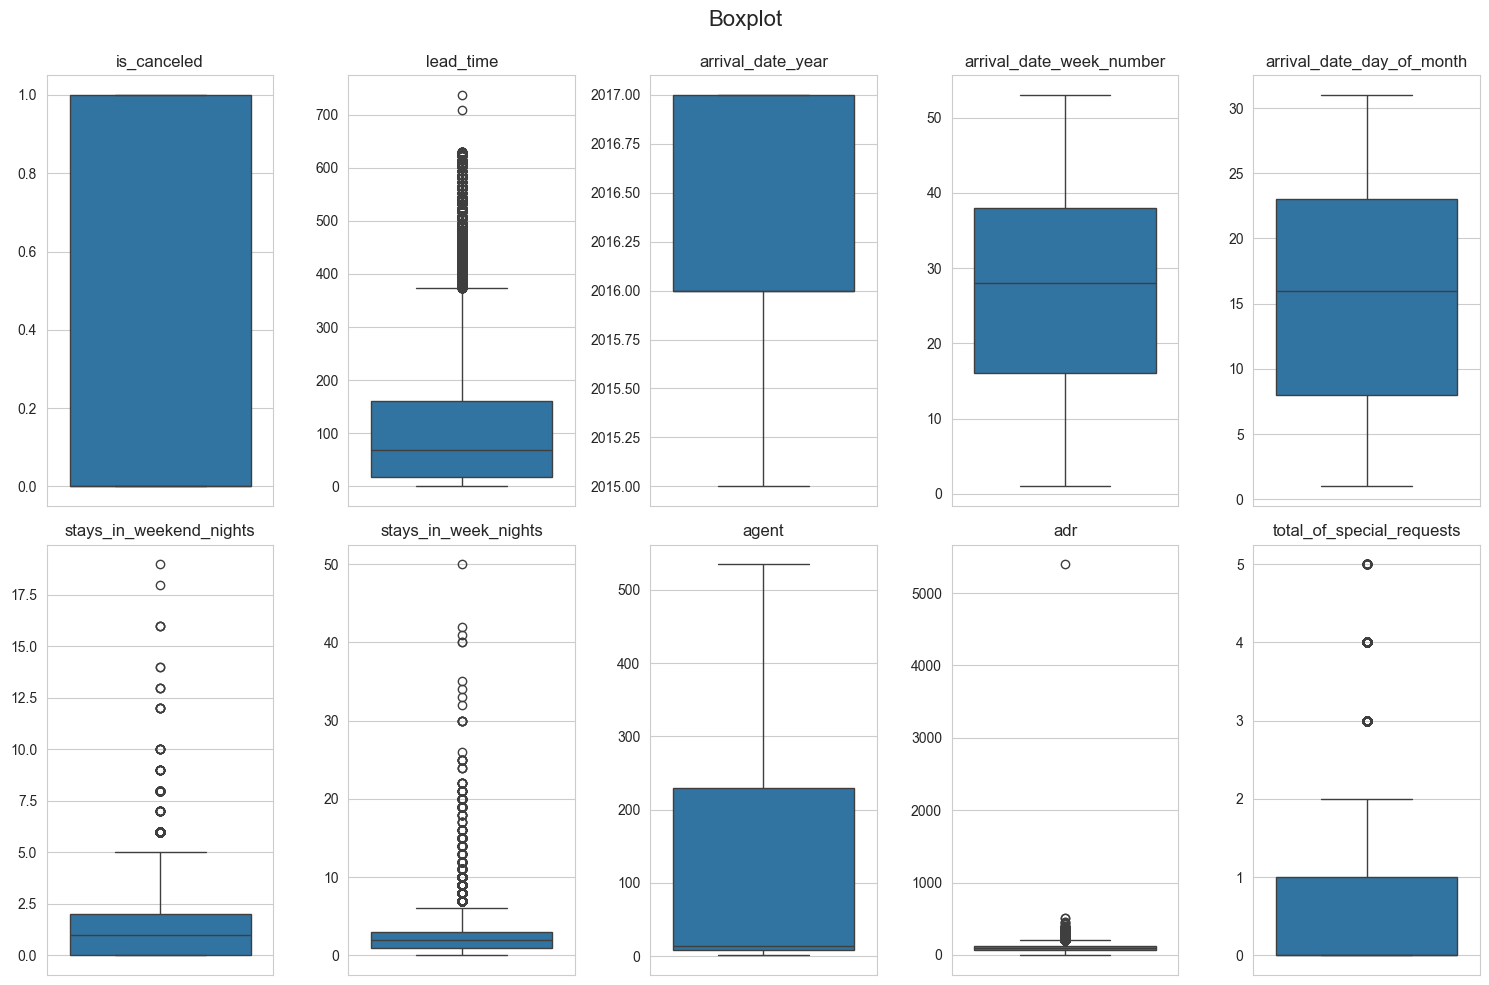

In [11]:
boxplot_visualization(data, numerical_columns_box,"Boxplot")

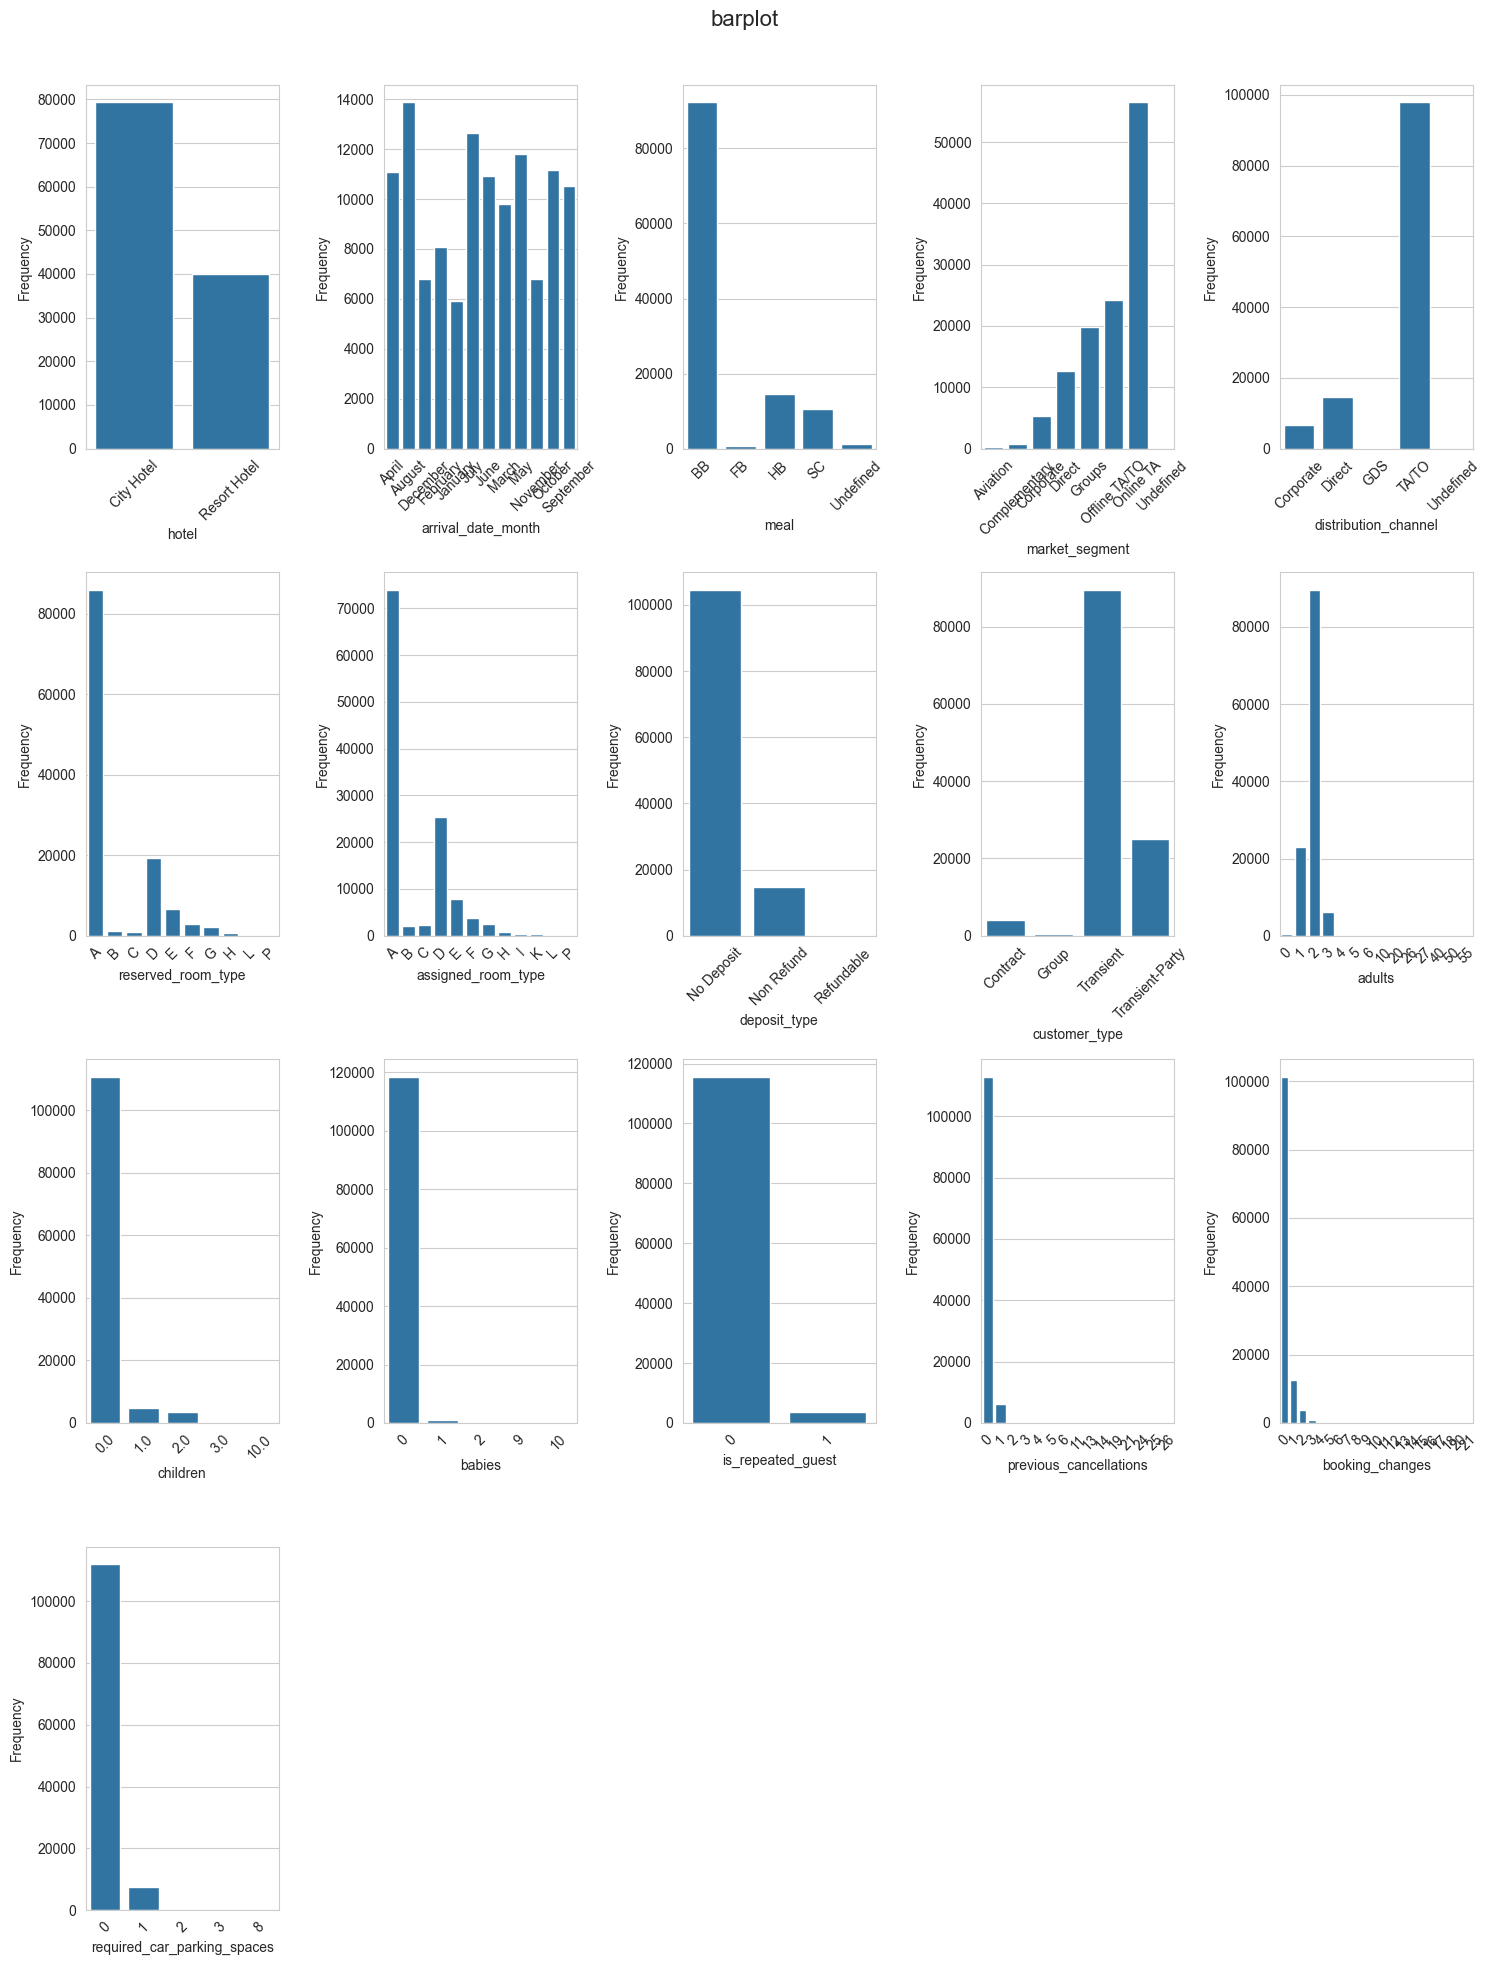

In [12]:
barplot_visualization(data, categorical_columns_barplot + numerical_columns_barplot,"barplot")

We can observe that the majority of the features are imbalanced, with some categories having a much higher frequency than others. 
There are also some rows that indicate that no adult is included in the booking which seems strange since normally children and babies don't stay in a hotel by themselves. Staying a total of 0 nights in the weekend seems too frequent. This characteristics may indicate some inconsistencies in the data.

In [13]:
data['is_canceled'].value_counts()

is_canceled
0    75166
1    44224
Name: count, dtype: int64

Our target column is unbalanced,with more non-canceled bookings than canceled bookings, which gives us some insights of the methods we need to use to train and test the models to avoid bias towards the majority class.

## Bivariate Analysis

Now we will analyse the features of the data by the target classes. This can help understand if some columns will be good predictors of the cancellations.

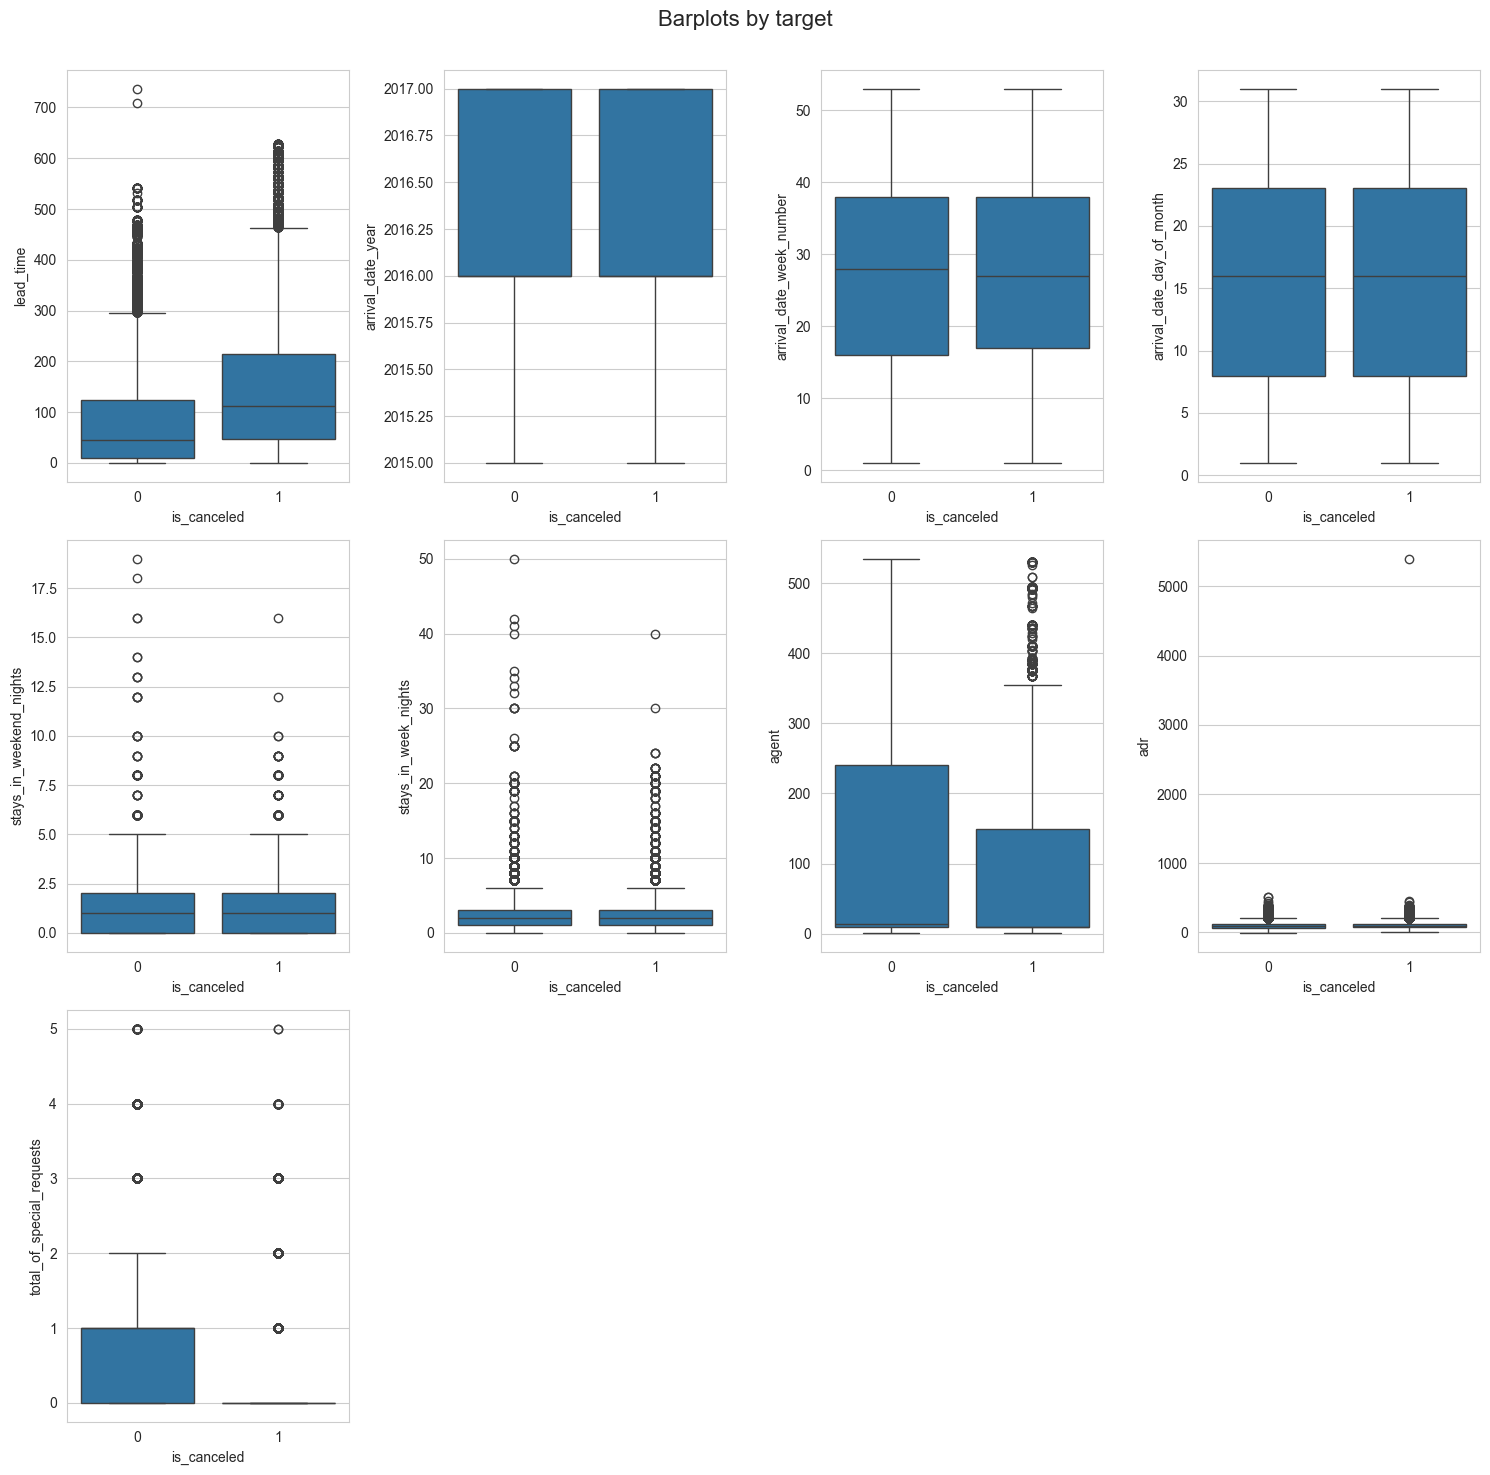

In [14]:
boxplot_by_type_visualization(data, numerical_columns_box, "Barplots by target")

We observe distinct distributions in the numerical features between the two classes of the target variable. For instance, the lead time for canceled bookings tends to be higher than for non-canceled bookings. Similar distinctions are evident in the agent and total_of_special_requests columns, suggesting that these features may serve as strong predictors.

These differences offer valuable insights for the model, helping it to identify patterns and improve its performance.

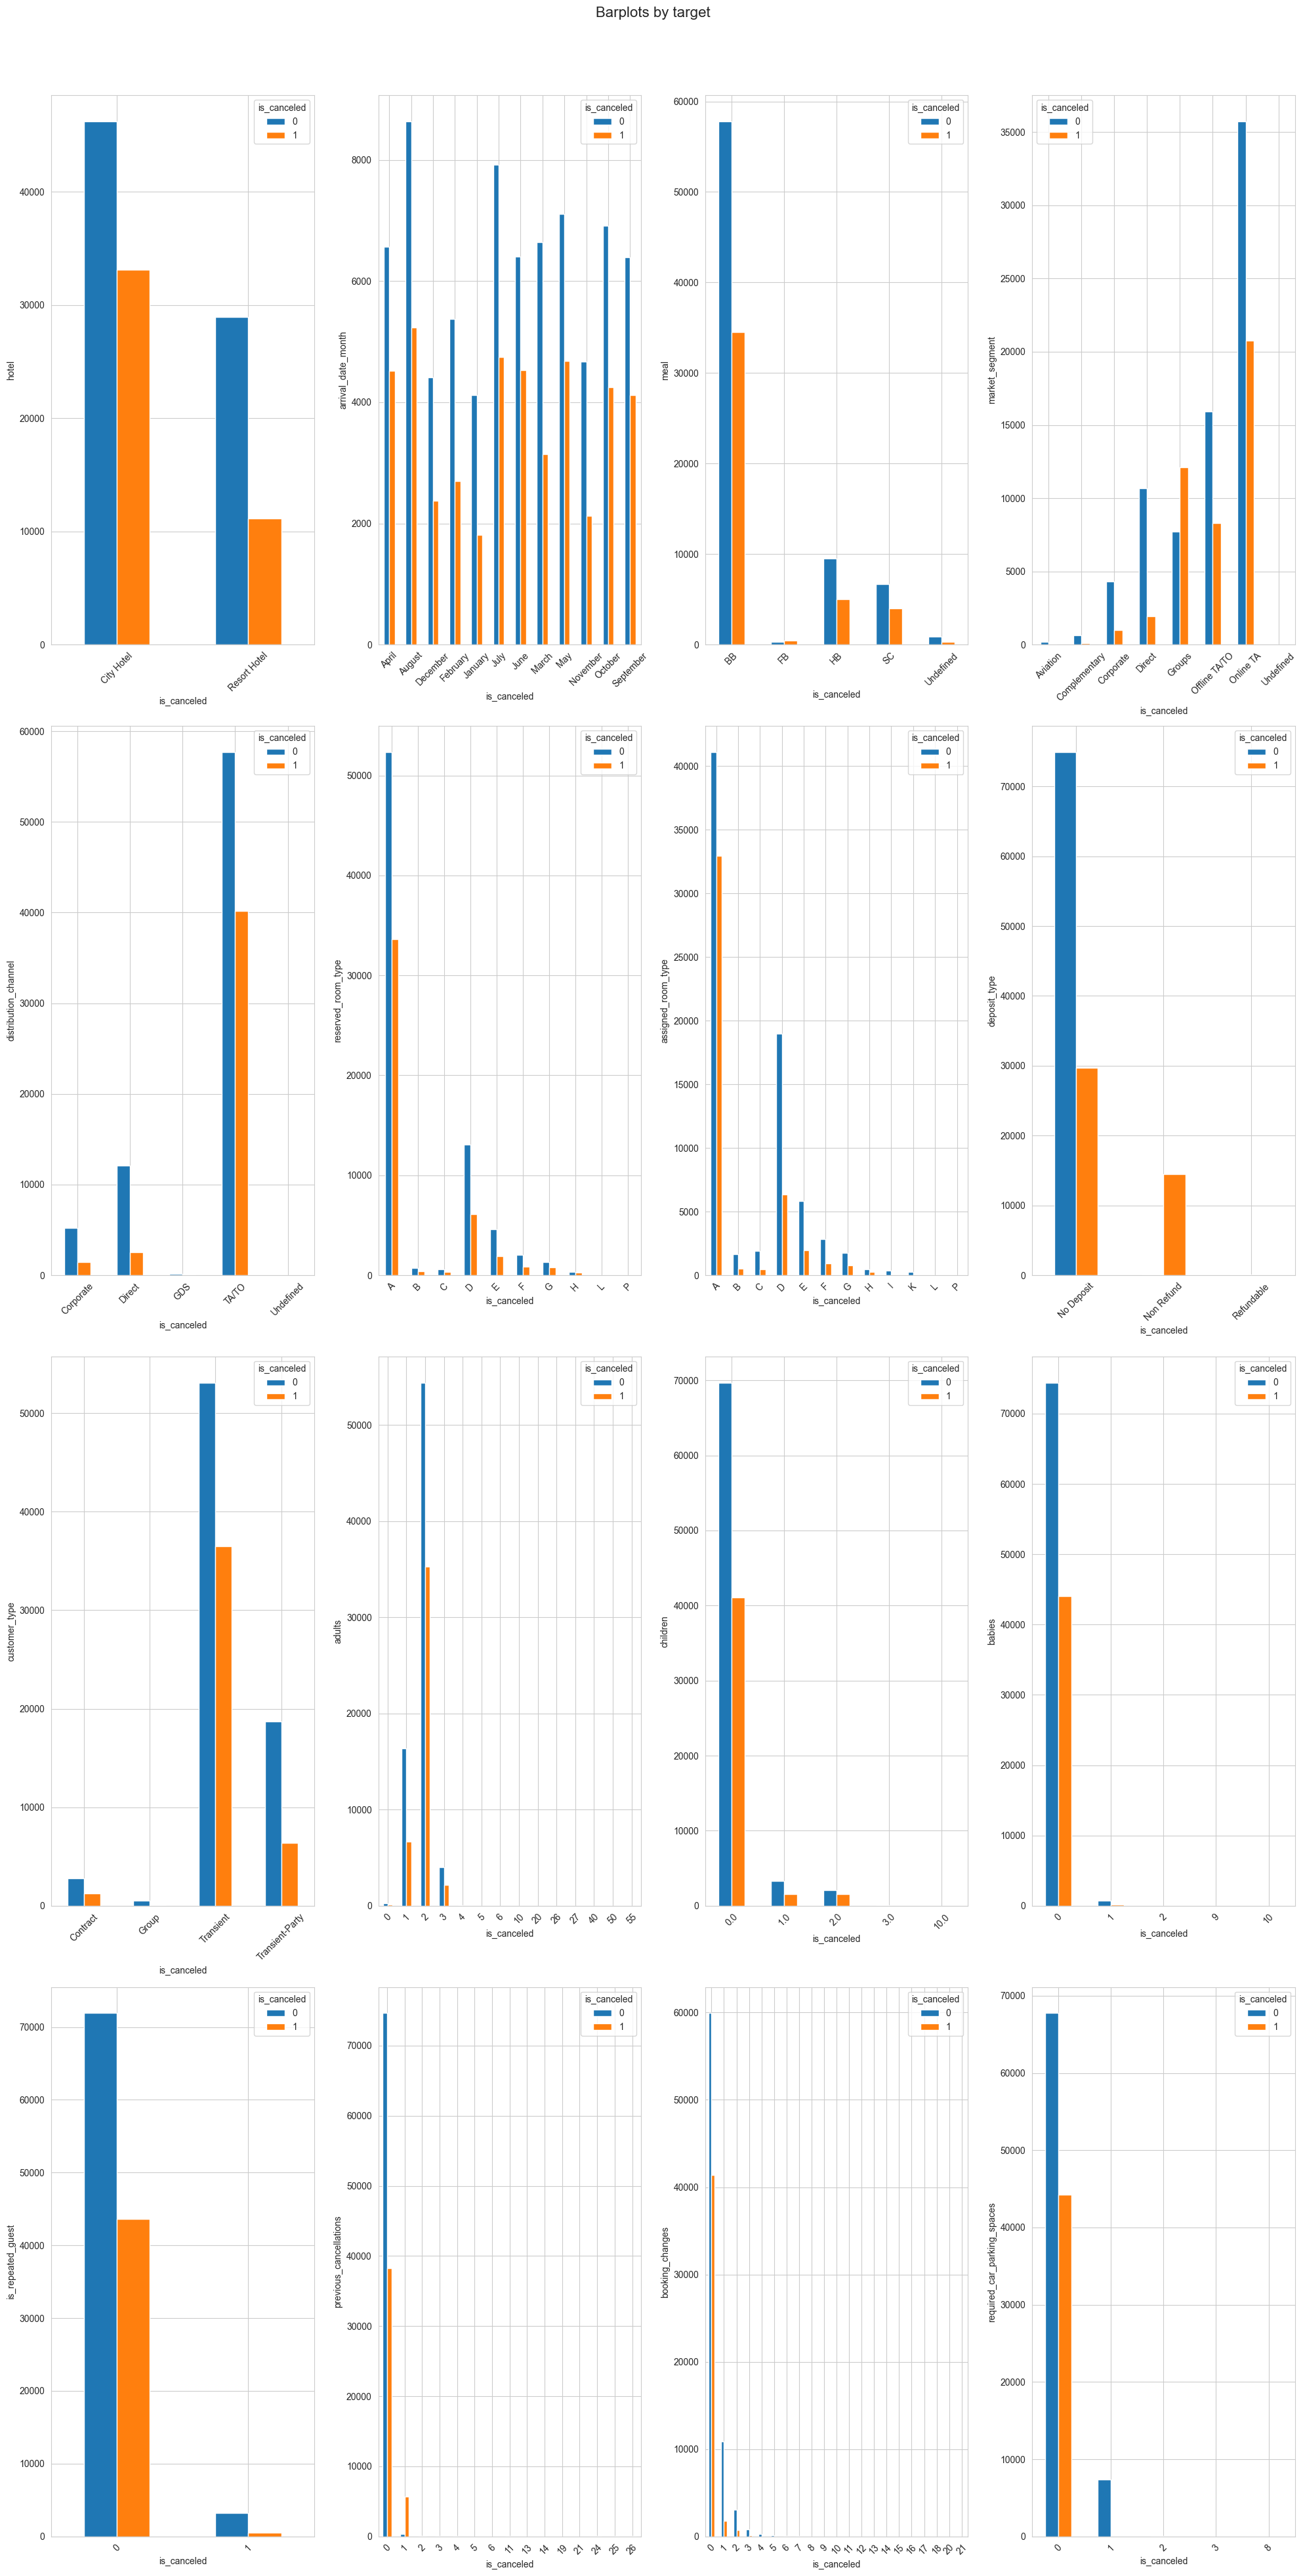

In [15]:
crosstab_by_type_visualization(data, categorical_columns_barplot + numerical_columns_barplot,'Barplots by target')

Some values are linked to a higher chance of cancellation. For example, bookings with a "Non Refund" deposit type are much more likely to be canceled. In contrast, some features have a lower cancellation rate compared to the total number of bookings, which shows the dataset is imbalanced.

There aren’t any obvious outliers as all values seem reasonable and may provide useful insights into cancellation patterns.

## Dealing with missing values

In [16]:
# Number of missing values in incomplete columns

data.isnull().sum()[data.isnull().sum() > 0]

children         4
country        488
agent        16340
company     112593
dtype: int64

In [17]:
# Percentage of missing values in incomplete columns

data.isnull().sum()[data.isnull().sum() > 0]/len(data) * 100

children     0.003350
country      0.408744
agent       13.686238
company     94.306893
dtype: float64

Given the large number of missing values (94.3%) in the company column, we can drop it.
The children and agent columns have a small number of missing values, so we can fill them with 0, assuming that the missing values are due to the absence of children or agents.
The country column has a small number of missing values, so we can fill them with the most frequent value.


In [18]:
# Assigning the new values to the columns and dropping the company column

data.drop(columns=['company'], axis = 1, inplace=True)
data[['children','agent']] = data[['children','agent']].fillna(0)
data['country'] = data['country'].fillna(data['country'].mode().iloc[0])

## Resolve inconsistencies
Since we are working with booking data, we decided to remove entries with 0 nights booked, 0 guests, and any duplicate rows. This cleanup ensures the dataset only includes meaningful records, which will help improve our model to uncover patterns within the data.

In [19]:
# Drop the rows that have a total of 0 nights booked, 0 guests and the duplicate rows.

data = data[data['stays_in_weekend_nights'] + data['stays_in_week_nights'] > 0]
data = data[(data['adults'] + data['children'] + data['babies']) > 0]
data = data.drop_duplicates()

## Encoding data
We will try two encoding methods, Label encoder and dummies and test all models with both ways to see what performs best.

In [20]:
# Encoding with LabelEncoder and OneHotEncoder

label_encoder = LabelEncoder()
data_encoded = data.copy()
for col in data.select_dtypes(include='object').columns:
    data_encoded[col] = label_encoder.fit_transform(data[col])

data_dummies = pd.get_dummies(data, columns=data.select_dtypes(include='object').columns)
dummy_columns = data_dummies.columns.difference(data.columns)
non_dummy_columns = data_dummies.columns.difference(dummy_columns)
non_dummy_columns = non_dummy_columns.drop('is_canceled')

# Data Pre-Processing
The data split includes a fixed random state, ensuring consistency across training and test sets. This approach allows the results to depend solely on the method used instead of variations in the data split. Additionally, we use stratification to maintain the same class distribution in both sets, which helps improve the model's ability to generalize across classes, which is helpful in our imbalanced dataset.

In [21]:
# Splitting the data into features and target

X_encoded = data_encoded.drop(columns=['is_canceled'])
y_encoded = data_encoded['is_canceled']

X_dummies = data_dummies.drop(columns=['is_canceled'])
y_dummies = data_dummies['is_canceled']


# Train-test split using holdout as our dataset is medium-sized
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_train_dummies, X_test_dummies, y_train_dummies, y_test_dummies = train_test_split(X_dummies, y_dummies, test_size=0.2, random_state=42, stratify=y_dummies)

## Scaling
Some models are sensitive to the range of the features, so we decided to scale the data. Scaling ensures that features with different ranges do not disproportionately influence the model, which can improve performance. We decided to not change the dummy columns as they do not require further transformation. Scaling these would not add value and could distort their interpretability within the model

In [22]:
# Using StandardScaler to obtain a normal distribution in the data

scaler = StandardScaler()
X_train_encoded_scaled = scaler.fit_transform(X_train_encoded)
X_test_encoded_scaled = scaler.transform(X_test_encoded)

# Not scaling the dummy columns since they are already normalized
X_train_dummies_scaled = X_train_dummies.copy()
X_test_dummies_scaled = X_test_dummies.copy()
X_train_dummies_scaled[non_dummy_columns] = scaler.fit_transform(X_train_dummies[non_dummy_columns])
X_test_dummies_scaled[non_dummy_columns] = scaler.transform(X_test_dummies[non_dummy_columns])

# Create models
Some models require additional attention to the type of data they receive. Some models need the data to be encoded as they only work with numerals and others need the data to be scaled to work properly. We will test every model with label encoded and dummy encoded data and we will choose the method that performs better for each case.
Since we are dealing with a classification problem, we will be using the following models as a baseline:
- K-Nearest  (Needs encoded and scaled data)
- Decision Tree (Needs encoded data)
- Neural Network (Needs encoded and scaled data)
- Naive Bayes (Needs encoded data)
- Support Vector Machine (Needs encoded and scaled data)

In [23]:
# Initializing the models

KNN = KNeighborsClassifier()
KNN_dummies = KNeighborsClassifier()
DT = DecisionTreeClassifier(max_depth=25)  # including max_depth parameter to avoid overfitting
DT_dummies = DecisionTreeClassifier(max_depth=25)  # including max_depth parameter to avoid overfitting
NN = MLPClassifier()
NN_dummies = MLPClassifier()
NB = GaussianNB()
NB_dummies = GaussianNB()
SVM = SVC()
SVM_dummies = SVC()

In [24]:
# Fitting the models using the same split data to ensure a fair comparison
    
KNN.fit(X_train_encoded_scaled, y_train_encoded)
KNN_dummies.fit(X_train_dummies_scaled, y_train_dummies)

DT.fit(X_train_encoded, y_train_encoded)
DT_dummies.fit(X_train_dummies, y_train_dummies)

NN.fit(X_train_encoded_scaled, y_train_encoded)
NN_dummies.fit(X_train_dummies_scaled, y_train_dummies)

NB.fit(X_train_encoded, y_train_encoded)
NB_dummies.fit(X_train_dummies, y_train_dummies)

SVM.fit(X_train_encoded_scaled, y_train_encoded)
SVM_dummies.fit(X_train_dummies_scaled, y_train_dummies)

message = "The fitting process is complete"
message

'The fitting process is complete'

# Evaluation

In [25]:
# Predicting the target variable

y_pred_KNN = KNN.predict(X_test_encoded_scaled)
y_pred_KNN_dummies = KNN_dummies.predict(X_test_dummies_scaled)

y_pred_DT = DT.predict(X_test_encoded)
y_pred_DT_dummies = DT_dummies.predict(X_test_dummies)

y_pred_NN = NN.predict(X_test_encoded_scaled)
y_pred_NN_dummies = NN_dummies.predict(X_test_dummies_scaled)

y_pred_NB = NB.predict(X_test_encoded)
y_pred_NB_dummies = NB_dummies.predict(X_test_dummies)

y_pred_SVM = SVM.predict(X_test_encoded_scaled)
y_pred_SVM_dummies = SVM_dummies.predict(X_test_dummies_scaled)

In [26]:
# Evaluating and printing the classification report for the models

print("KNN Report:")
display(classification_report_print(y_test_encoded, y_pred_KNN))

print("KNN Dummies Report:")
display(classification_report_print(y_test_dummies, y_pred_KNN_dummies))

print("Decision Tree Report:")
display(classification_report_print(y_test_encoded, y_pred_DT))

print("Decision Tree Dummies Report:")
display(classification_report_print(y_test_dummies, y_pred_DT_dummies))

print("Neural Network Report:")
display(classification_report_print(y_test_encoded, y_pred_NN))

print("Neural Network Dummies Report:")
display(classification_report_print(y_test_dummies, y_pred_NN_dummies))

print("Naive Bayes Report:")
display(classification_report_print(y_test_encoded, y_pred_NB))

print("Naive Bayes Dummies Report:")
display(classification_report_print(y_test_dummies, y_pred_NB_dummies))

print("Support Vector Machine Report:")
display(classification_report_print(y_test_encoded, y_pred_SVM))

print("Support Vector Machine Dummies Report:")
display(classification_report_print(y_test_dummies, y_pred_SVM_dummies))

KNN Report:


,precision,recall,f1-score,support
0,0.84,0.87,0.86,12526.0
1,0.63,0.57,0.6,4745.0
,,,,
accuracy,,,0.79,17271.0
macro avg,0.73,0.72,0.73,17271.0
weighted avg,0.78,0.79,0.79,17271.0


KNN Dummies Report:


,precision,recall,f1-score,support
0,0.85,0.87,0.86,12526.0
1,0.63,0.6,0.61,4745.0
,,,,
accuracy,,,0.79,17271.0
macro avg,0.74,0.73,0.73,17271.0
weighted avg,0.79,0.79,0.79,17271.0


Decision Tree Report:


,precision,recall,f1-score,support
0,0.86,0.87,0.87,12526.0
1,0.65,0.63,0.64,4745.0
,,,,
accuracy,,,0.8,17271.0
macro avg,0.75,0.75,0.75,17271.0
weighted avg,0.8,0.8,0.8,17271.0


Decision Tree Dummies Report:


,precision,recall,f1-score,support
0,0.87,0.87,0.87,12526.0
1,0.65,0.65,0.65,4745.0
,,,,
accuracy,,,0.81,17271.0
macro avg,0.76,0.76,0.76,17271.0
weighted avg,0.81,0.81,0.81,17271.0


Neural Network Report:


,precision,recall,f1-score,support
0,0.86,0.9,0.88,12526.0
1,0.7,0.62,0.66,4745.0
,,,,
accuracy,,,0.82,17271.0
macro avg,0.78,0.76,0.77,17271.0
weighted avg,0.82,0.82,0.82,17271.0


Neural Network Dummies Report:


,precision,recall,f1-score,support
0,0.87,0.9,0.89,12526.0
1,0.72,0.65,0.68,4745.0
,,,,
accuracy,,,0.83,17271.0
macro avg,0.8,0.78,0.79,17271.0
weighted avg,0.83,0.83,0.83,17271.0


Naive Bayes Report:


,precision,recall,f1-score,support
0,0.91,0.31,0.46,12526.0
1,0.34,0.92,0.49,4745.0
,,,,
accuracy,,,0.48,17271.0
macro avg,0.62,0.61,0.48,17271.0
weighted avg,0.75,0.48,0.47,17271.0


Naive Bayes Dummies Report:


,precision,recall,f1-score,support
0,0.88,0.49,0.63,12526.0
1,0.38,0.82,0.52,4745.0
,,,,
accuracy,,,0.58,17271.0
macro avg,0.63,0.66,0.58,17271.0
weighted avg,0.74,0.58,0.6,17271.0


Support Vector Machine Report:


,precision,recall,f1-score,support
0,0.84,0.93,0.88,12526.0
1,0.74,0.53,0.62,4745.0
,,,,
accuracy,,,0.82,17271.0
macro avg,0.79,0.73,0.75,17271.0
weighted avg,0.81,0.82,0.81,17271.0


Support Vector Machine Dummies Report:


,precision,recall,f1-score,support
0,0.85,0.93,0.89,12526.0
1,0.77,0.57,0.65,4745.0
,,,,
accuracy,,,0.83,17271.0
macro avg,0.81,0.75,0.77,17271.0
weighted avg,0.83,0.83,0.82,17271.0


Since the dataset is imbalanced, we will focus on metrics that provide deeper insight into performance beyond accuracy, particularly recall and precision for each class.

Overall, models performed better with dummy-encoded features, showing a higher recall for class 1 (canceled bookings), though recall for class 0 (not canceled) decreased. Based on these results, we will move forward exclusively with dummy encoding, as it demonstrates stronger performance for our target class.

When examining recall, we see that class 0 recall is generally high, meaning there’s a low rate of misclassifying non-canceled bookings as canceled. In contrast, class 1 recall is lower, indicating that canceled bookings are more often misclassified as non-canceled. Naive Bayes is an exception here, achieving high recall for class 1 but at the cost of reduced recall for class 0.

To address these performance variations, we will explore ensemble methods to combine models, aiming to balance recall across both classes and improve overall predictive results.

#### Confusion matrices

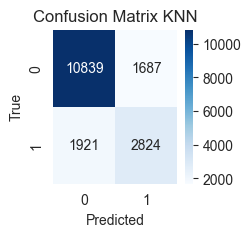

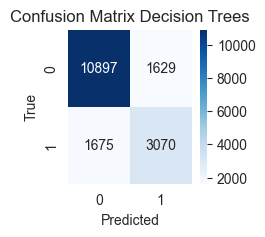

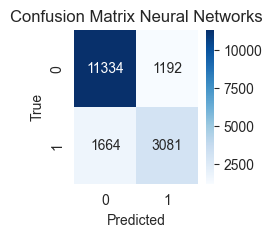

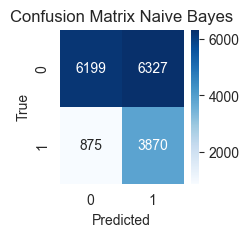

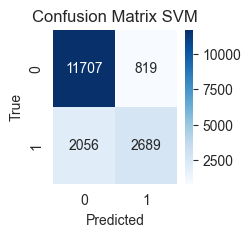

In [27]:
# Plot the Confusion Matrices of the models with dummies data

plot_confusion_matrix(y_test_dummies, y_pred_KNN_dummies,suffix='KNN')
plot_confusion_matrix(y_test_dummies, y_pred_DT_dummies, suffix='Decision Trees')
plot_confusion_matrix(y_test_dummies, y_pred_NN_dummies, suffix='Neural Networks')
plot_confusion_matrix(y_test_dummies, y_pred_NB_dummies, suffix='Naive Bayes')
plot_confusion_matrix(y_test_dummies, y_pred_SVM_dummies, suffix='SVM')

When looking into the confusion matrices, we can conclude that the majority of the models have the number of False Positives and False Negatives in the same magnitude, meaning that they are not being biased towards one class.
Naive Bayes is an exception, having a big number of False Positives and a small number of False Negatives. This shows that the model is biased towards the 1 class. The very low precision of the 1 class is also a sign of this bias, so we can conclude that the model is not performing well despite the high recall of the 1 class.

Although the SVM has a low number of misclassifications for class 0, it is nearly matching this with an equal number of misclassifications for class 1 as correct guesses. This indicates that the overall performance is not meeting expectations; despite having good precision for class 1, the recall remains low. This is particularly concerning in a scenario where false negatives carry significant consequences, as it suggests that the model may not effectively identify canceled bookings, which could lead to costly errors in decision-making.

#### Ensemble Models

We will attempt to combine the models to enhance predictions using various methods. The reasons for this approach include increased predictive power, as leveraging the strengths of multiple models can lead to better overall performance.

The Naive Bayes model will be used since it has a high recall for class 1 and the Neural Networks because they are good predictors of the 0 class.

With this we hope to balance the overall recall, obtaining better results for our specific needs of predicting well the canceled booking, while not mistaking too much not canceled ones.

#####  Weighted Average Ensemble

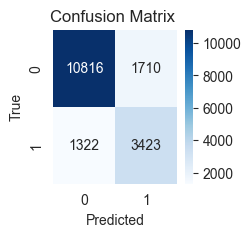

,precision,recall,f1-score,support
0,0.89,0.86,0.88,12526.0
1,0.67,0.72,0.69,4745.0
,,,,
accuracy,,,0.82,17271.0
macro avg,0.78,0.79,0.79,17271.0
weighted avg,0.83,0.82,0.83,17271.0


In [28]:
# This is the best combination of weights we could achieve

y_pred_proba_wae = 0.7 * NN_dummies.predict_proba(X_test_dummies_scaled) + 0.3 * NB_dummies.predict_proba(X_test_dummies)
y_pred_WAE = np.argmax(y_pred_proba_wae, axis=1)

# Confusion matrix
plot_confusion_matrix(y_test_dummies, y_pred_WAE)

# Classification Report 
classification_report_print(y_test_dummies, y_pred_WAE)

##### Hybrid Model - Class-Based Model Selection

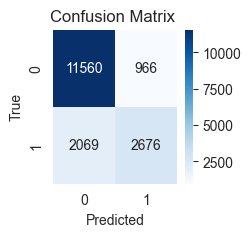

,precision,recall,f1-score,support
0,0.85,0.92,0.88,12526.0
1,0.73,0.56,0.64,4745.0
,,,,
accuracy,,,0.82,17271.0
macro avg,0.79,0.74,0.76,17271.0
weighted avg,0.82,0.82,0.82,17271.0


In [29]:
# Combining the predictions of two models, one for each class

y_pred_model_0 = NN_dummies.predict(X_test_dummies_scaled)
y_pred_model_1 = NB_dummies.predict(X_test_dummies)
y_pred_HM = np.where(y_pred_model_0 == 0, y_pred_model_0, y_pred_model_1)

# Confusion matrix
plot_confusion_matrix(y_test_dummies, y_pred_HM)

# Classification Report 
classification_report_print(y_test_dummies, y_pred_HM)

##### Stacking Classifier

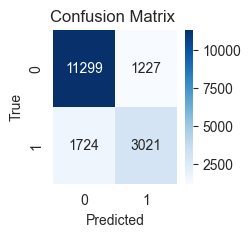

,precision,recall,f1-score,support
0,0.87,0.9,0.88,12526.0
1,0.71,0.64,0.67,4745.0
,,,,
accuracy,,,0.83,17271.0
macro avg,0.79,0.77,0.78,17271.0
weighted avg,0.82,0.83,0.83,17271.0


In [30]:
# Using Naive Bayes and Neural Networks as base models and Logistic Regression as the meta learner

meta_model = LogisticRegression()
estimators = [
    ('NN', NN_dummies),
    ('NB', NB_dummies)
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=meta_model)
stacking_clf.fit(X_train_dummies_scaled, y_train_dummies)
y_pred_stacking_clf = stacking_clf.predict(X_test_dummies_scaled)

# Confusion matrix
plot_confusion_matrix(y_test_dummies, y_pred_stacking_clf)

# Classification Report 
classification_report_print(y_test_dummies, y_pred_stacking_clf)

##### Voting Classifier

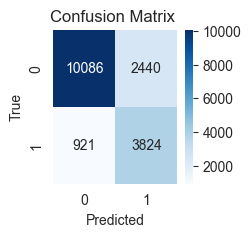

,precision,recall,f1-score,support
0,0.92,0.81,0.86,12526.0
1,0.61,0.81,0.69,4745.0
,,,,
accuracy,,,0.81,17271.0
macro avg,0.76,0.81,0.78,17271.0
weighted avg,0.83,0.81,0.81,17271.0


In [31]:
# Using Naive Bayes, Neural Networks and Decision Trees with soft voting. The inclusion of Decision Trees is due to the balanced recall for both classes.

estimators=[
    ('nn', NN_dummies), 
    ('nb', NB_dummies), 
    ('dt', DT_dummies)
]

voting_clf = VotingClassifier(estimators=estimators, voting='soft')

voting_clf.fit(X_train_dummies_scaled, y_train_dummies)
y_pred_voting_clf = voting_clf.predict(X_test_dummies_scaled)

# Confusion matrix
plot_confusion_matrix(y_test_dummies, y_pred_voting_clf)

# Classification Report 
classification_report_print(y_test_dummies, y_pred_voting_clf)

Given the nature of the problem, where False Negatives may be more harmful than False Positives, we can conclude that the Weighted Average Ensemble model is the best model so far in terms of the metrics. It has a high recall for both classes and the f1-score is the best of them all. The metrics are still not balanced, with clear disparity between the classes that shows that there still are room for improvement.

#### ROC Curve
We will plot the ROC curve for the compatible models to evaluate their performance.

In [32]:
models_scaled= {
    'SVM':SVM_dummies,
    'Neural Network': NN_dummies,
    'KNN': KNN_dummies,
    'Voting Model': voting_clf,
    'Stacking Model': stacking_clf 
}

models_not_scaled = {
    'Decision Tree':DT_dummies,
    'Naive Bayes':NB_dummies
}

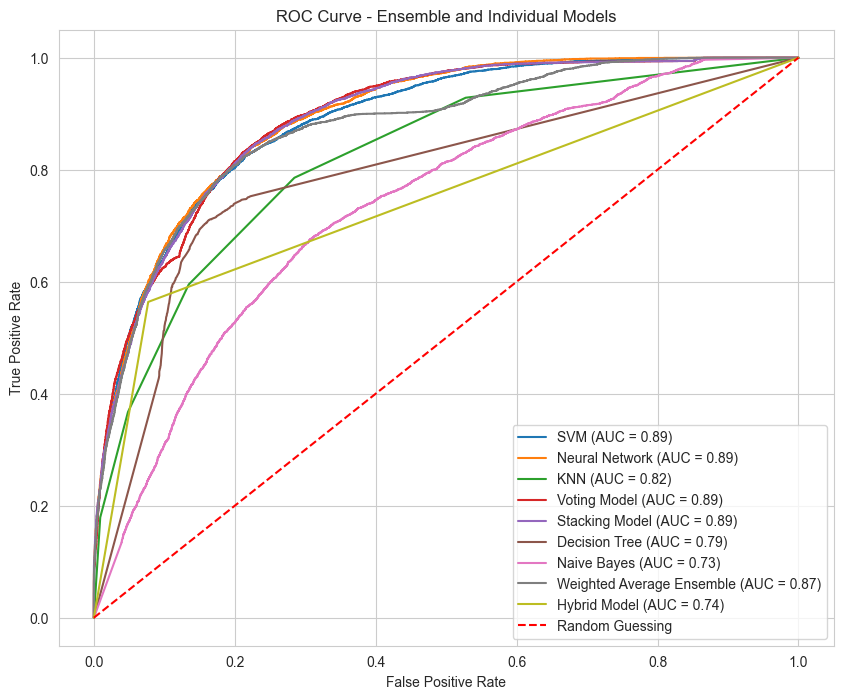

In [33]:
roc_data_scaled = roc_curve_data(models_scaled ,X_test_dummies_scaled, y_test_dummies)

roc_data_not_scaled = roc_curve_data(models_not_scaled, X_test_dummies, y_test_dummies)
roc_data = roc_data_scaled |roc_data_not_scaled

## Add Weighted Average Ensemble
y_pred_proba_wae = y_pred_proba_wae[:, 1] 
fpr_wae, tpr_wae, _ = roc_curve(y_test_dummies, y_pred_proba_wae)
auc_wae = auc(fpr_wae, tpr_wae)
roc_data['Weighted Average Ensemble'] = (fpr_wae, tpr_wae, auc_wae)

## Add Hybrid Model
fpr_HM, tpr_HM, _ = roc_curve(y_test_dummies, y_pred_HM)
auc_HM = auc(fpr_HM, tpr_HM)
roc_data['Hybrid Model'] = (fpr_HM, tpr_HM, auc_HM)

roc_curve_visualization(roc_data)

The ROC curve shows that the Weighted Average Ensemble model, the SVM Voting model, stacking model and the Neural Networks had the highest AUC value, close to 0.9, meaning that they performed the best among the models.
The Naive Bayes and the hybrid model had the lowest AUC value.
Since the curves of the best and worst models intercept each other, we can conclude that some models are better for some cost ratios than others.

## Second approach
Since Naive Bayes did not perform well, and it has no hyperparameters to tune, we will not use it in the next steps.
The SVM model has a low recall for the 1 class, so we will not use it either in the next steps.
We will keep KNN, Decision Trees, Neural Networks in future tests and evaluate the ensemble models.
In the next steps we will evaluate the importance of the current features in order to gain insights of which we can remove. We will also perform feature engineering if we see as necessary as well as feature selection. Then the tests will be repeated to see if the results improved.

### Data preparation

#### Data Reduction

Since only the Decision Trees support feature importance, we will analyse which ones we can remove without impacting the model negatively, by also using the correlation matrix.

In [34]:
get_feature_importances_text(X_train_dummies.columns ,DT_dummies.feature_importances_)

Feature Importances:
- lead_time: 0.142
- country_PRT: 0.108
- total_of_special_requests: 0.084
- adr: 0.074
- agent: 0.065
- arrival_date_day_of_month: 0.051
- market_segment_Online TA: 0.048
- arrival_date_week_number: 0.047
- required_car_parking_spaces: 0.042
- arrival_date_year: 0.034
- stays_in_week_nights: 0.031
- booking_changes: 0.020
- deposit_type_Non Refund: 0.020
- previous_cancellations: 0.017
- stays_in_weekend_nights: 0.017
- customer_type_Transient: 0.015
- adults: 0.010
- assigned_room_type_A: 0.009
- reserved_room_type_A: 0.007
- previous_bookings_not_canceled: 0.006
- children: 0.005
- market_segment_Direct: 0.005
- arrival_date_month_July: 0.005
- meal_BB: 0.005
- reserved_room_type_D: 0.004
- country_ESP: 0.004
- country_FRA: 0.004
- arrival_date_month_June: 0.004
- country_DEU: 0.004
- country_GBR: 0.004
- arrival_date_month_May: 0.004
- meal_HB: 0.004
- customer_type_Transient-Party: 0.004
- assigned_room_type_D: 0.003
- arrival_date_month_August: 0.003
- meal_S

In [35]:
correlation_matrix = data_dummies.corr()

abs(correlation_matrix['is_canceled']).sort_values(ascending=False).round(3)

is_canceled                    1.000
market_segment_Online TA       0.214
required_car_parking_spaces    0.185
lead_time                      0.181
deposit_type_Non Refund        0.164
                               ...  
country_MCO                    0.000
agent                          0.000
country_IRN                    0.000
country_ECU                    0.000
country_GRC                    0.000
Name: is_canceled, Length: 255, dtype: float64

Some of the most important features have a high correlation with the target variable. This is the case for market_segment_Online TA, required_car_parking_spaces, lead_time, deposit_type_Non Refund, adr and others. Since they match we will assign a threshold to the correlation matrix and exclude all features that do not meet the criteria.

In [36]:
# Identifying all the features that have a correlation above 0.01%

data_features = correlation_matrix[abs(correlation_matrix['is_canceled']).sort_values(ascending=False).round(3) >= 0.01].index

In [37]:
# Keeping only the features identified above

data_dummies = data_dummies[data_features]

##### Feature engineering
We can verify that the correlation between the features and the target is low and given the fact that some pairs of columns can provide some insight on the possible cancellation status, we will create some features.

We considered that the number of the week may be useful since it may indicate the seasonality of the bookings that can be associated with cancellations. With the following graphs the distribution of the feature will be analysed in order to understand how the values might be grouped.

We tried to create features that showed the season of the year per booking, and also one that showed if the booking occurred during the holidays. We had no success with these features, so we decided to not include them.

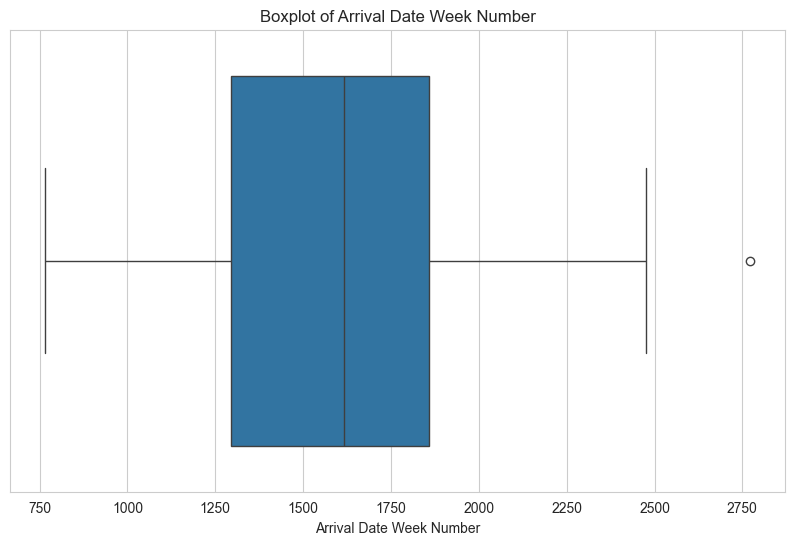

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['arrival_date_week_number'].value_counts())
plt.xlabel('Arrival Date Week Number')
plt.title('Boxplot of Arrival Date Week Number')
plt.show()

We decided to group on 4 categories, depending on the quantiles of frequency.

In [39]:
# The categories represent the reservations made with up to 7 seven days in advance, up to one month and more than one month

def lead_time_category(lead_time):
    if lead_time <= 7:
        return 0
    elif 7 < lead_time <= 30:
        return 1
    else:
        return 2


# Calculating the quantiles of frequency
week_counts = data['arrival_date_week_number'].value_counts()
q1 = week_counts.quantile(0.25)
q2 = week_counts.quantile(0.5)
q3 = week_counts.quantile(0.75)

# Categorizing the frequency using the quantiles
def categorize_frequency(week):
    freq = week_counts[week]
    if freq <= q1:
        return 0
    elif q1 < freq <= q2:
        return 1
    elif q2 < freq <= q3:
        return 2
    else:
        return 3

In [40]:
# Creating new features using other columns

data_dummies['room_type_match'] = (data['reserved_room_type'] == data['assigned_room_type']).astype(int)
data_dummies['num_people'] = data['adults'] + data['children'] + data['babies']
data_dummies['lead_time_category'] = data['lead_time'].apply(lead_time_category)
data_dummies['arrival_date_week_frequency_category'] = data['arrival_date_week_number'].apply(categorize_frequency)

'Room_type_match' indicates wether the guest got the pretended room or not since it may contribute for its unsatisfaction and a possible cancellation.

'Num_people' indicates the total number of people included in the bookings. We decided to test that since larger groups might have an effect on the cancellations since of the necessity of managing different schedules of the guests.

We also grouped 'lead_time' into categories: less than a week, less than a month and longer.

##### Lasso
In order to further reduce the number of features, the Lasso method will be employed.

We chose Lasso for feature selection because it works well with one-hot encoded data, where each feature is binary. Lasso helps by shrinking the least important features to zero, keeping only the most relevant ones. The C parameter that refers to the inverse of the regularization stregth will be used with the value 0.5. With this choice we wanted to have medium regularization since C=0.1 is a stronger regularization and C=1 equals to less regularization.

ANOVA and Chi-square weren’t suitable because they’re better for testing individual categorical features rather than many binary features. Lasso also handles overlapping information between features, which is common in one-hot encoding. Also, ANOVA is less reliable when the target in imbalanced, which is the case.

In [41]:
X, df = lasso_regularization(data_dummies.drop(columns='is_canceled'),data_dummies['is_canceled'])

Number of removed features : 2
Removed features: Index(['adults', 'customer_type_Contract'], dtype='object')


We were expecting that some other columns would be removed as there are a lot more features that showed less correlation with the target that the ones removed by the Lasso method.

##### Outliers
We decided not to eliminate the outliers in order to be left with few data to train the models, which could lead to decreased performance. Another reason was that every value of the features is valid, despite being extreme, as they may represent unique cases or important variations in the dataset that could enhance our understanding and improve the model's ability to generalize.

### Data pre-processing

In [62]:
# Using the stratify method to ensure the same distribution of classes in the train and test

y = df['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Creation and evaluation of the models

#### KNN
We will use grid search to determine the value for K that maximizes roc score.

Best parameters {'n_neighbors': 11}
Best Score 0.8194193774099704


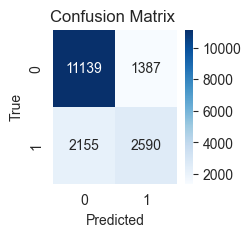

,precision,recall,f1-score,support
0,0.84,0.89,0.86,12526.0
1,0.65,0.55,0.59,4745.0
,,,,
accuracy,,,0.79,17271.0
macro avg,0.74,0.72,0.73,17271.0
weighted avg,0.79,0.79,0.79,17271.0


In [43]:
# the function best_k_for_KNN tests all odd numbers from 3 to 151 and returns the best estimator

KNN = best_k_for_KNN(X_train,y_train)
y_pred_KNN = KNN.predict(X_test)

# Confusion matrix
plot_confusion_matrix(y_test,y_pred_KNN)

# Classification Report 
classification_report_print(y_test, y_pred_KNN)

#### Random Forest
Instead of using a simple Decision Tree we decided to use RandomForest classifier to see if we can improve the results, using grid search to maximize the roc_auc score.

Best parameters {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 500}
Best Score 0.9009660948369624


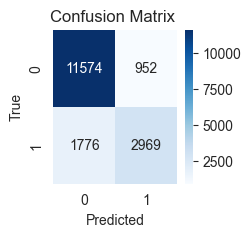

,precision,recall,f1-score,support
0,0.87,0.92,0.89,12526.0
1,0.76,0.63,0.69,4745.0
,,,,
accuracy,,,0.84,17271.0
macro avg,0.81,0.77,0.79,17271.0
weighted avg,0.84,0.84,0.84,17271.0


In [44]:
# The function best_random_forest tests different values for the n_estimators, max_depth and max_features and return the best estimator

RF = best_random_forest(X_train, y_train)
y_pred_RF = RF.predict(X_test)

# Confusion matrix
plot_confusion_matrix(y_test, y_pred_RF)

# Classification Report 
classification_report_print(y_test, y_pred_RF)

#### Neural Networks
We will perform a grid search to find the best parameters for the Neural Networks

Best parameters {'activation': 'logistic', 'alpha': 0.01}
Best Score 0.8896366848706545


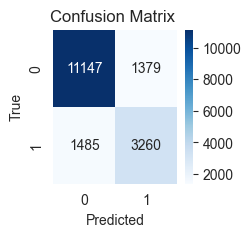

,precision,recall,f1-score,support
0,0.88,0.89,0.89,12526.0
1,0.7,0.69,0.69,4745.0
,,,,
accuracy,,,0.83,17271.0
macro avg,0.79,0.79,0.79,17271.0
weighted avg,0.83,0.83,0.83,17271.0


In [45]:
# The function best_neural_network tests different activation functions and alpha values and returns the best estimator

NN = best_neural_network(X_train,y_train)
y_pred_NN = NN.predict(X_test)

# Confusion matrix
plot_confusion_matrix(y_test,y_pred_NN)

# Classification Report 
classification_report_print(y_test, y_pred_NN)

#### Voting Classifier

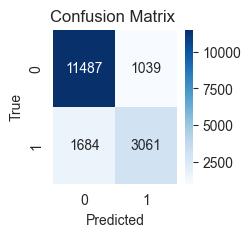

,precision,recall,f1-score,support
0,0.87,0.92,0.89,12526.0
1,0.75,0.65,0.69,4745.0
,,,,
accuracy,,,0.84,17271.0
macro avg,0.81,0.78,0.79,17271.0
weighted avg,0.84,0.84,0.84,17271.0


In [46]:
# We will combine the three different models and use soft voting

estimators = [
    ('knn', KNN), 
    ('rf', RF), 
    ('nn', NN)
]
voting_clf = VotingClassifier(estimators=estimators, voting='soft')
voting_clf.fit(X_train,y_train)
y_pred_voting_clf = voting_clf.predict(X_test)

# Confusion matrix
plot_confusion_matrix(y_test, y_pred_voting_clf)

# Classification Report 
classification_report_print(y_test, y_pred_voting_clf)

#### Stacking Classifier

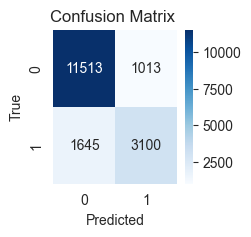

,precision,recall,f1-score,support
0,0.87,0.92,0.9,12526.0
1,0.75,0.65,0.7,4745.0
,,,,
accuracy,,,0.85,17271.0
macro avg,0.81,0.79,0.8,17271.0
weighted avg,0.84,0.85,0.84,17271.0


In [47]:
# We will use the three models and a logistic regression as the metamodel

meta_model = LogisticRegression()

estimators = [
    ('knn', KNN), 
    ('rf', RF), 
    ('nn', NN)
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=meta_model)
stacking_clf.fit(X_train, y_train)
y_pred_stacking_clf = stacking_clf.predict(X_test)

# Confusion matrix
plot_confusion_matrix(y_test, y_pred_stacking_clf)

# Classification Report 
classification_report_print(y_test, y_pred_stacking_clf)

#### Hybrid Model - Class-Based Model Selection

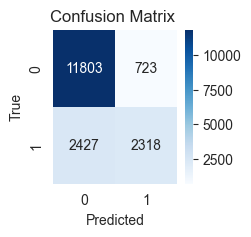

,precision,recall,f1-score,support
0,0.83,0.94,0.88,12526.0
1,0.76,0.49,0.6,4745.0
,,,,
accuracy,,,0.82,17271.0
macro avg,0.8,0.72,0.74,17271.0
weighted avg,0.81,0.82,0.8,17271.0


In [48]:
# Combining the predictions of two models, one for each class

y_pred_model_1 = KNN.predict(X_test)
y_pred_model_2 = NN.predict(X_test)
y_pred_HM = np.where(y_pred_model_1 == 0, y_pred_model_1, y_pred_model_2)

# Confusion matrix
plot_confusion_matrix(y_test, y_pred_HM)

# Classification Report 
classification_report_print(y_test, y_pred_HM)

#### Weighted Average Ensemble

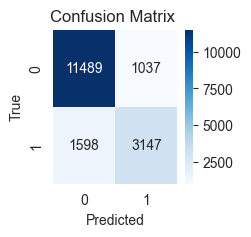

,precision,recall,f1-score,support
0,0.88,0.92,0.9,12526.0
1,0.75,0.66,0.7,4745.0
,,,,
accuracy,,,0.85,17271.0
macro avg,0.82,0.79,0.8,17271.0
weighted avg,0.84,0.85,0.84,17271.0


In [49]:
# We decided to use only Neural Networks and Random Forest, as they demonstrated the best performance among the three models tested. This choice also helps to reduce the complexity associated with searching for optimal weights. This combination provided the most effective results in our analysis.

weight_1 = 0.4
weight_2 = 0.6
y_pred_proba_wae = weight_1 * NN.predict_proba(X_test) + weight_2 * RF.predict_proba(X_test)
y_pred_WAE = np.argmax(y_pred_proba_wae, axis=1)

# Confusion matrix
plot_confusion_matrix(y_test, y_pred_WAE)

# Classification Report 
classification_report_print(y_test, y_pred_WAE)

### ROC curve

In [50]:
models = {
    'KNN': KNN,
    'RandomForestClassifier': RF,
    'Neural Network': NN,
    'VotingClassifier': voting_clf,
    'StackingClassifier': stacking_clf
}

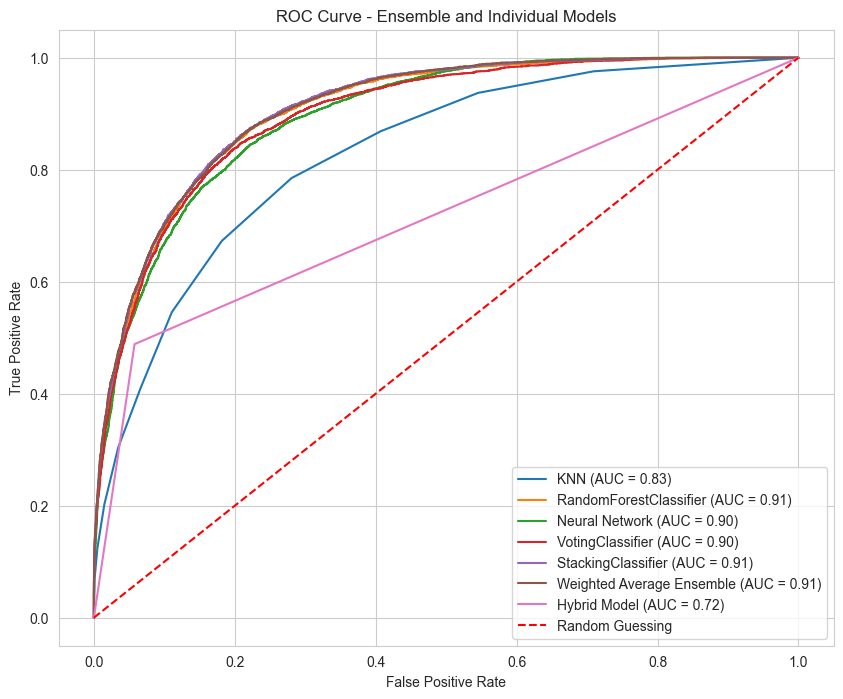

In [51]:
roc_data = roc_curve_data(models,X_test,y_test)

## Add Weighted Average Ensemble
y_pred_proba_wae = y_pred_proba_wae[:, 1] 
fpr_wae, tpr_wae, _ = roc_curve(y_test_dummies, y_pred_proba_wae)
auc_wae = auc(fpr_wae, tpr_wae)
roc_data['Weighted Average Ensemble'] = (fpr_wae, tpr_wae, auc_wae)

## Add Hybrid Model
fpr_HM, tpr_HM, _ = roc_curve(y_test_dummies, y_pred_HM)
auc_HM = auc(fpr_HM, tpr_HM)
roc_data['Hybrid Model'] = (fpr_HM, tpr_HM, auc_HM)

roc_curve_visualization(roc_data)

The ROC curve shows that the best performing models were the Stacking Classifier and the Random Forest. The Neural Networks, Voting Classifier, and Weighted Average Ensemble were very close in performance. The worst performers were the KNN and Hybrid model. The best models did not intersect with the worst models, indicating a clear separation in their predictive capabilities. This suggests that the top-performing models consistently achieved higher true positive rates while maintaining lower false positive rates across various thresholds. 

## Third approach

In the last approach we will test if with undersampling we can obtain better results. By reducing the number of instances in the majority class, we aim to balance the dataset, which may help improve the model's ability to learn patterns associated with the minority class. This technique can lead to a more equitable distribution of data points, potentially enhancing the model's performance on the less frequent class and improving overall recall. As the data will no longer be unbalanced, we can evaluate the accuracy as well.
 
We will only test the best model with the same hyperparameters obtained by the grid search and the best ensemble model. To do that we also need to train the neural networks since it is used in the Stacking Classifier.

### Undersampling

We decided to manage the class imbalance by using sampling methods. Given that the majority class has nearly three times the frequency of the minority class, we opted against oversampling. Oversampling would introduce excessive redundancy by duplicating minority class samples, which could lead to overfitting and less generalizable models. Instead, we focused on undersampling, which reduces the size of the majority class to achieve a more balanced dataset without artificially inflating the minority class. This approach helps our model learn patterns more effectively across both classes. The same reasoning applies to the Hybrid model, where in this case could also lead to overfitting.

In [67]:
# Generating a balanced train dataset, choosing random samples of the original train

y = df['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class_counts = y_train.value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()

minority_class_indices = y_train[y_train == minority_class].index
majority_class_indices = y_train[y_train == majority_class].index

undersampled_majority_indices = np.random.choice(majority_class_indices, size=len(minority_class_indices), replace=False)
undersampled_indices = np.concatenate([minority_class_indices, undersampled_majority_indices])

X_train_balanced = X_train.loc[undersampled_indices]
y_train_balanced = y_train.loc[undersampled_indices]

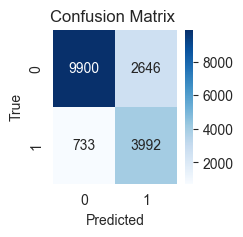

,precision,recall,f1-score,support
0,0.93,0.79,0.85,12546.0
1,0.6,0.84,0.7,4725.0
,,,,
accuracy,,,0.8,17271.0
macro avg,0.77,0.82,0.78,17271.0
weighted avg,0.84,0.8,0.81,17271.0


In [68]:
# Random Forest with balanced train data

RF = RandomForestClassifier(max_depth=30, max_features = 'sqrt', n_estimators = 400)
RF.fit(X_train_balanced, y_train_balanced)
y_pred_RF = RF.predict(X_test)

# Confusion matrix
plot_confusion_matrix(y_test, y_pred_RF)

# Classification Report 
classification_report_print(y_test, y_pred_RF)

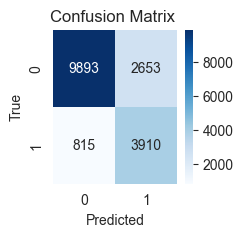

,precision,recall,f1-score,support
0,0.92,0.79,0.85,12546.0
1,0.6,0.83,0.69,4725.0
,,,,
accuracy,,,0.8,17271.0
macro avg,0.76,0.81,0.77,17271.0
weighted avg,0.83,0.8,0.81,17271.0


In [69]:
# Neural Network with balanced train data

NN = MLPClassifier(activation='logistic', alpha = 0.01)
NN.fit(X_train_balanced, y_train_balanced)
y_pred_NN = NN.predict(X_test)

# Confusion matrix
plot_confusion_matrix(y_test,y_pred_NN)

# Classification Report 
classification_report_print(y_test, y_pred_NN)

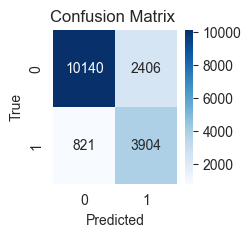

,precision,recall,f1-score,support
0,0.93,0.81,0.86,12546.0
1,0.62,0.83,0.71,4725.0
,,,,
accuracy,,,0.81,17271.0
macro avg,0.77,0.82,0.79,17271.0
weighted avg,0.84,0.81,0.82,17271.0


In [70]:
# Random Forest and Neural Network as estimators and logistic regression as the metamodel with balanced train data 

meta_model = LogisticRegression()

estimators = [
    ('rf', RF), 
    ('nn', NN)
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=meta_model)
stacking_clf.fit(X_train_balanced, y_train_balanced)
y_pred_stacking_clf = stacking_clf.predict(X_test)

# Confusion matrix
plot_confusion_matrix(y_test, y_pred_stacking_clf)

# Classification Report 
classification_report_print(y_test, y_pred_stacking_clf)

The performance of the models was slightly worse. This can be due to the loss of training data.

## Results

Through various iterations and adjustments, we observed that the second approach significantly improved model performance.

Undersampling led to suboptimal results, likely due to the loss of information caused by the substantial data imbalance, which limited the model's capacity for accurate generalization.

We made some decisions, like the use of holdout as our datset is not considered small. We tried stratification of the train and test to check if the imbalance would be less noticeable. The cross validation method was employed in the grid search as a way to better validate the results.

In this project, we explored multiple approaches, including testing various models, experimenting with combinations, and fine-tuning through hyperparameter optimization using grid search. For the Weighted Average Ensemble (WAE) model, we manually adjusted class weights, testing different configurations to identify the optimal balance. Identifying less important features and creating new, more relevant ones, alongside diverse testing approaches, led us to develop what we believe is a well-rounded solution to the problem.

To evaluate model performance and understand the impact of these adjustments, we relied on multiple metrics and visualizations. This helped us assess how each change influenced model performance and effectiveness.

Looking at the final results, we identified the Random Forest model as the top performer, making it a strong candidate for accurately predicting hotel cancellations.